# FIT5149 Assessment 1: Relative Performance — Monash Index

Due Date: 23:55, Wednesday, 17 September 2025


---



#### A1Group_11:

Member 1: Maria Valentina Ovalle Velandia, (Student ID), mova0001@student.monash.edu, Contribution

Member 2: Carlos Gustavo Valbuena Vargas, (35203447), cval0016@student.monash.edu, Contribution

---

# SETUP

###  Libraries

In [26]:
import os, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from scipy import stats
from scipy.special import expit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import (f1_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score, mean_absolute_error, r2_score)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance


Note: you may need to restart the kernel to use updated packages.


###  Reproductibility

In [28]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); os.environ['PYTHONHASHSEED'] = str(SEED)
TRAIN_END = '2023-06'
PREDICT_MONTH = '2023-07'
MACRO_LAG = 1
BASE = Path('.')
sns.set(style='whitegrid')

### Helper Functions

In [29]:
def parse_month_id(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace('_','-', regex=False)
    return s.apply(lambda x: pd.Period(x, freq='M'))

def split_feature_columns(df: pd.DataFrame):
    exclude = {'stock_id','feature_month','target_month','y_cls','y_reg','month_id'}
    num_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude).tolist()
    cat_cols = [c for c in df.columns if c not in num_cols and c not in exclude]
    return num_cols, cat_cols

def ohe_compatible():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

# PIPELINE OVERVIEW



1.   **Business Understanding:** Define the business frame, two predictive tasks aligned with the investment objective (classification and regression), and metrics of success (F1-score, RMSE, and outperforming the benchmark).
2.   **Data Understanding:** Load and explore stock-level returns, company characteristics, and macroeconomic indicators. Verify the structure of the dataset (42 months × 616 stocks), check feature types (numerical and categorical), and ensure correct alignment of stock IDs, months, and target variables.
3.   **Data Preparation:** Convert month to a proper time format and enforce chronological ordering. Split features into numerical and categorical groups. Apply preprocessing with imputation (median for numerical, most frequent for categorical), scaling, and one-hot encoding. Ensure transformations are encapsulated within pipelines to prevent data leakage.
4.   **Modeling:**
*   **Classification task:** Train Logistic Regression, Random Forest, and Histogram Gradient Boosting models, compared against a majority-class baseline.
*   **Regression task:** Train Ridge Regression, Random Forest Regressor, and Histogram Gradient Boosting Regressor, compared against a mean baseline.
5.   **Evaluation:** Compare candidate models against baselines. Select the classifier with the highest average F1-score and the regressor with the lowest average RMSE.
6.   **Deployment:** Retrain selected models using all data up to June 2023. Generateste predictions for July 2023 and save them in the required testing_targets.csv file with the four specified columns: stock_id, month, y_cls_pred, y_reg_pred. Ensure reproducibility with fixed random seeds and a self-contained workflow.

# BUSINESS UNDERSTANDING

**Context and Objective**

The primary objective of this project is to support investment decision-making by developing predictive models that identify stocks with high potential to outperform the market. Within the scenario, as junior quantitative analysts preparing monthly recommendations for July 2023, the benchmark is the US Monash Index, a proprietary index that represents the baseline return any competent portfolio manager should achieve. The business value of this analysis lies in generating systematic and data-driven insights that enhance portfolio construction, reduce investment risk, and increase returns relative to the benchmark.

**Primary taks**

From a business perspective, two levels of predictive tasks are defined. The primary task is a binary classification problem: determining whether a stock will outperform or underperform the US Monash Index in a target month. This task addresses the need for a clear decision signal to guide portfolio selection. The advanced task is a regression problem: estimating the magnitude of excess return, which provides finer granularity for risk-adjusted allocation decisions.

**Success crirteria**

Success in this context is defined through two complementary evaluation metrics that reflect the distinct nature of the predictive tasks. For the classification pipeline, the F1-score was adopted as the key measure because it balances precision and recall, ensuring that the model effectively identifies outperforming stocks without overemphasizing either false positives or false negatives. For the regression pipeline, the Root Mean Squared Error (RMSE) was used to capture the magnitude of prediction errors in excess returns, providing a clear indication of how closely the model tracks financial outcomonth.

### Available Information for the Task

The datasets provide a structured set of predictors that can be grouped into three levels:

*   **Micro (company_info):** strategic and financial positioning of each firm.
*   **Montho (stock_data, targets)**: stock-level performance relative to the benchmark.
*   **Macro (optional_data, Monash Index):** economic and market environment shaping returns.

Dataframonth and features

*  **Corporate metadata (company_info.csv)**: enables firms to be categorised into risk–opportunity archetypes. Provides the qualitative foundation to interpret returns beyond raw numbers, linking corporate strategy with financial robustness.
*  **Benchmark index(monashIndex.csv)**: sets the baseline every portfolio manager is expected to beat. Serves as a relative success metric in model evaluation.
*  **Stock-level data (stock_data.csv)**: captures market behaviour and allows assessment of stock sensitivity to shocks. Forms the quantitative basis for constructing predictive signals.
*  **Economic indicators (optional data)**: these indicators incorporate macroeconomic and financial context, capturing systemic factors that influence all firms and condition relative investment attractiveness.



# DATA UNDERSTANDING

Este bloque explora las variables de training y características antes del modelado, para justificar la selección de señales, transformaciones y precauciones.
- Métodos univariados: tipos, faltantes, distribución (hist/KDE), asimetría y transformaciones (log1p).
- Métodos bivariados: correlaciones de Spearman con y_cls/y_reg, patrones por sector y size, y mapas 2D de interacción.
- Temporalidad: rate de positivos vs retorno del índice y VIX para entender regímenes.
- Outliers: IQR y winsorización segura (no leakage temporal).
Estas evidencias motivan: (i) usar escalado + OHE, (ii) incluir macros con lag, (iii) tratar colas pesadas en volúmenes/ratios, (iv) preferir modelos no lineales (RF/HGB).


### Data loading (relative paths)

In [30]:
# NOTE
# stock = pd.read_csv(BASE/'stock_data.csv')
# index_df = pd.read_csv(BASE/'monashIndex.csv')
# company = pd.read_csv(BASE/'company_info.csv')
# vix = pd.read_csv(BASE/'vix_index.csv')
# us10y = pd.read_csv(BASE/'us_10_year_treasury.csv')
# us5y = pd.read_csv(BASE/'us_5_year_treasury.csv')
# infl = pd.read_csv(BASE/'fed_inflation_rate.csv')
# fedrate = pd.read_csv(BASE/'fed_funds_rate.csv')
# unemp = pd.read_csv(BASE/'fed_unemployment_rate.csv')
# train_tgt = pd.read_csv(BASE/'training_targets.csv').astype({'stock_id':'str'})
# test_tgt = pd.read_csv(BASE/'testing_targets.csv').astype({'stock_id':'str'})


# stock['stock_id'] = stock['stock_id'].astype(str)
# company['stock_id'] = company['stock_id'].astype(str)
# stock['month'] = parse_month_id(stock['month_id'])
# index_df['month'] = parse_month_id(index_df['month_id'])
# for df, col in [(vix,'vix'), (us10y,'10y_treasury'), (us5y,'5y_treasury'), (infl,'inflation_rate'), (fedrate,'fed_rate'), (unemp,'unemployment_rate')]:
#     df['month'] = parse_month_id(df['month_id'])

# print('Stock months:', stock['month'].min(), '->', stock['month'].max(), 'rows=', len(stock))
# print('Train months:', train_tgt['month_id'].min(), '->', train_tgt['month_id'].max(), 'rows=', len(train_tgt))
# display(stock.head(3))

In [31]:
stock = pd.read_csv('stock_data.csv')
index_df = pd.read_csv('monashIndex.csv')
company = pd.read_csv('company_info.csv')
vix = pd.read_csv('vix_index.csv')
us10y = pd.read_csv('us_10_year_treasury.csv')
us5y = pd.read_csv('us_5_year_treasury.csv')
infl = pd.read_csv('fed_inflation_rate.csv')
fedrate = pd.read_csv('fed_funds_rate.csv')
unemp = pd.read_csv('fed_unemployment_rate.csv')
train_tgt = pd.read_csv('training_targets.csv').astype({'stock_id':'str'})
test_tgt = pd.read_csv('testing_targets.csv').astype({'stock_id':'str'})

### Data Harmonisation

In [32]:
stock['stock_id'] = stock['stock_id'].astype(str)
company['stock_id'] = company['stock_id'].astype(str)
stock['month'] = parse_month_id(stock['month_id'])
index_df['month'] = parse_month_id(index_df['month_id'])
for df, col in [(vix,'vix'), (us10y,'10y_treasury'), (us5y,'5y_treasury'), (infl,'inflation_rate'), (fedrate,'fed_rate'), (unemp,'unemployment_rate')]:
    df['month'] = parse_month_id(df['month_id'])

print('Stock months:', stock['month'].min(), '->', stock['month'].max(), 'rows=', len(stock))
print('Train months:', train_tgt['month_id'].min(), '->', train_tgt['month_id'].max(), 'rows=', len(train_tgt))
display(stock.head(3))

Stock months: 2020-01 -> 2023-06 rows= 25618
Train months: 2020_01 -> 2023_06 rows= 25618


,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,return_6m,intramonth_volatility,volatility_3m,volatility_6m,trading_days,avg_volume_3m,volume_ratio,price_range_ratio,month
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,-0.030041,-0.075676,0.253304,0.278396,0.201608,21,3182487.0,1.207,0.136875,2020-01
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,-0.112968,-0.060752,0.259208,0.245523,0.192782,19,3686371.0,1.126,0.110905,2020-02
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,-0.219214,-0.154874,0.892709,0.088364,0.213051,22,5360363.0,1.509,0.268931,2020-03


### Data Overview

Summary of numerical and categorical columns

In [33]:
# Usar dataset original "stock" para el overview univariado
dfu = stock.copy()
num_cols_all = dfu.select_dtypes(include=['number']).columns.tolist()
cat_cols_all = [c for c in dfu.columns if c not in num_cols_all and c not in ['month']]
summary = []
for c in dfu.columns:
    miss = dfu[c].isna().mean()
    dtype = str(dfu[c].dtype)
    if c in num_cols_all:
        s = pd.to_numeric(dfu[c], errors='coerce')
        summary.append([c, dtype, miss, s.mean(), s.std(), s.min(), s.max()])
    else:
        summary.append([c, dtype, miss, None, None, None, None])
dict_df = pd.DataFrame(summary, columns=['feature','dtype','missing_rate','mean','std','min','max']).sort_values('missing_rate', ascending=False)
display(dict_df.head(20))


,feature,dtype,missing_rate,mean,std,min,max
10,return_6m,float64,0.005270,9.373876e-02,3.970243e-01,-0.878101,1.994221e+01
13,volatility_6m,float64,0.005270,3.563752e-01,2.407778e-01,0.020767,4.904750e+00
9,return_3m,float64,0.002459,4.224258e-02,2.245368e-01,-0.891459,6.892996e+00
12,volatility_3m,float64,0.002459,3.371325e-01,2.804322e-01,0.001361,7.123194e+00
16,volume_ratio,float64,0.001639,1.005413e+00,2.094507e-01,0.046000,2.602000e+00
15,avg_volume_3m,float64,0.001639,5.641095e+06,2.094349e+07,144.000000,6.000172e+08
8,return_1m,float64,0.000820,1.474041e-02,1.255801e-01,-0.832263,3.197183e+00
11,intramonth_volatility,float64,0.000078,3.844895e-01,2.530385e-01,0.037019,3.458247e+00
17,price_range_ratio,float64,0.000000,1.755904e-01,1.266333e-01,0.010922,3.457143e+00
14,trading_days,int64,0.000000,2.094441e+01,1.194822e+00,0.000000,2.300000e+01


Distributions and transformation suggestions

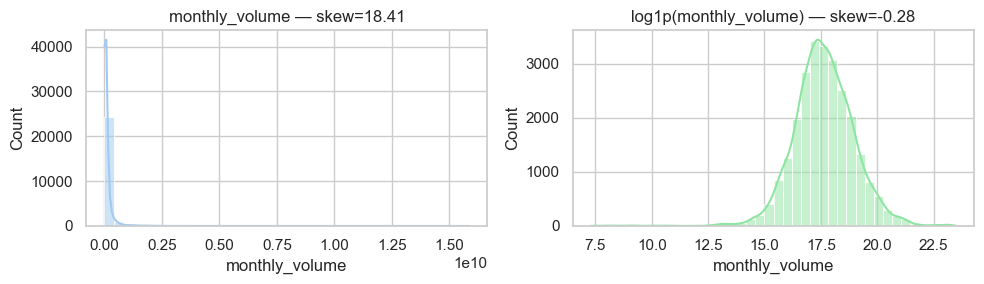

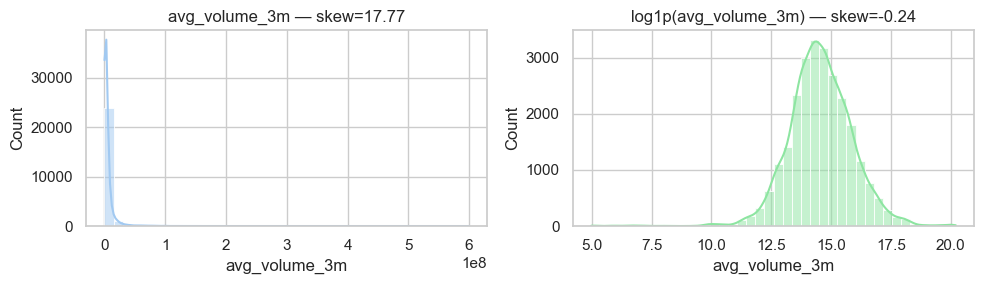

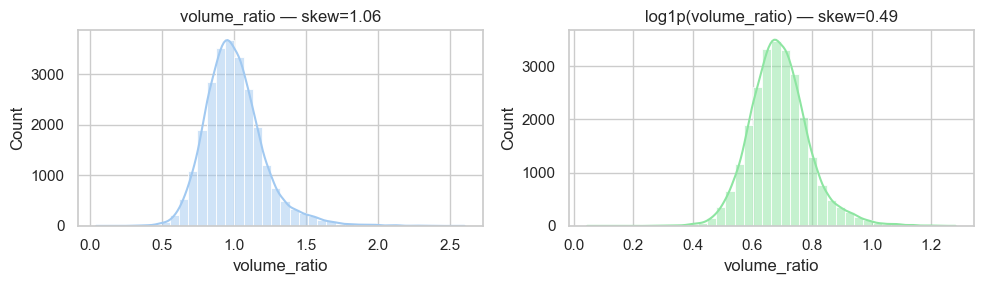

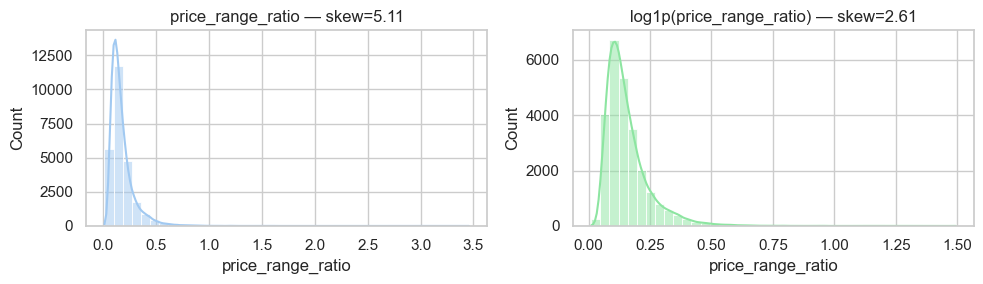

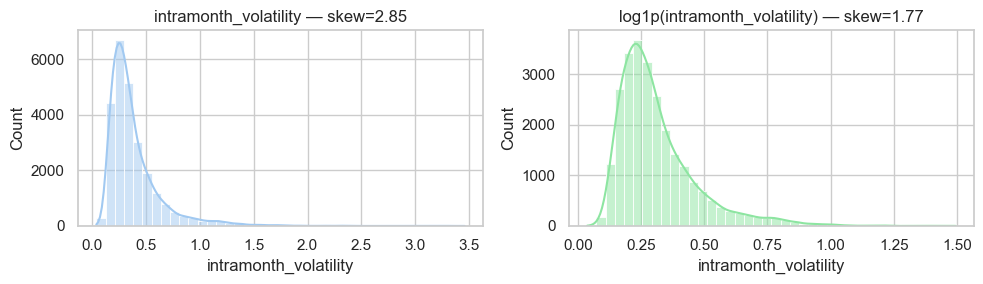

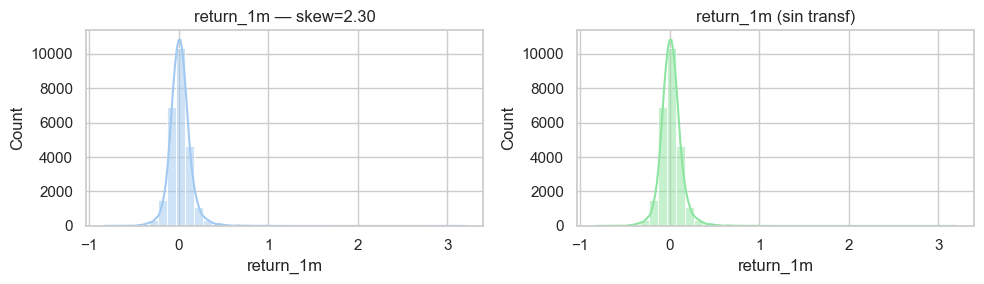

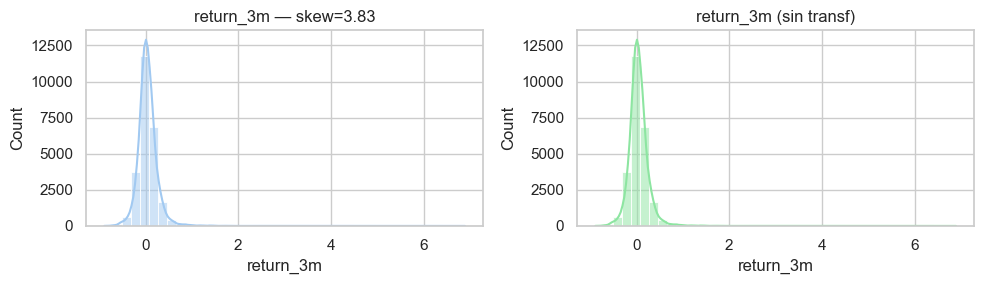

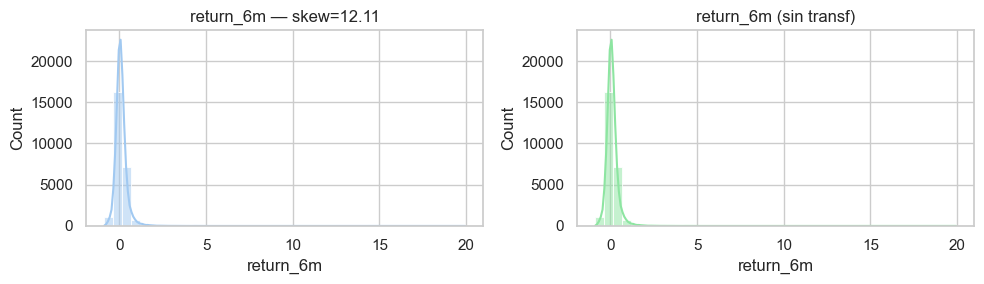

In [34]:
cand = [c for c in ['monthly_volume','avg_volume_3m','volume_ratio','price_range_ratio','intramonth_volatility','return_1m','return_3m','return_6m'] if c in stock.columns]
for c in cand:
    s = pd.to_numeric(stock[c], errors='coerce').dropna()
    if s.empty:
        continue
    sk = float(skew(s))
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1); sns.histplot(s, bins=40, kde=True, color='#A1C9F1'); plt.title(f'{c} — skew={sk:.2f}')
    if (s>=0).all():
        s_tr = np.log1p(s)
        sk2 = float(skew(s_tr))
        plt.subplot(1,2,2); sns.histplot(s_tr, bins=40, kde=True, color='#8DE5A1'); plt.title(f'log1p({c}) — skew={sk2:.2f}')
    else:
        plt.subplot(1,2,2); sns.histplot(s, bins=40, kde=True, color='#8DE5A1'); plt.title(f'{c} (sin transf)')
    plt.tight_layout(); plt.show()


### Partnerships with Goals

We select y_cls and y_reg as objective columns:
* y_cls: Indicates whether the stock outperformed the index (1) or not (0). Metric: F1.
* y_reg: Continuous excess return: stock return − index return. Metric: RMSE.



In [35]:
# NOTE
tmp = stock.copy()
tmp['target_month'] = tmp['month'] + 1
tt = train_tgt.copy()
tt['month'] = parse_month_id(tt['month_id'])
eda_train = tmp.merge(tt[['stock_id','month','outperform_binary','excess_return']],
                      left_on=['stock_id','target_month'], right_on=['stock_id','month'], how='inner', suffixes=('', '_y'))
eda_train = eda_train.rename(columns={'outperform_binary':'y_cls','excess_return':'y_reg'})
exclude = {'stock_id','month','target_month','y_cls','y_reg'}
num_feats = [c for c in eda_train.columns if (c not in exclude) and pd.api.types.is_numeric_dtype(eda_train[c])]
rows = []
for c in num_feats:
    s = pd.to_numeric(eda_train[c], errors='coerce')
    sr_cls = spearmanr(s, eda_train['y_cls'], nan_policy='omit')
    sr_reg = spearmanr(s, eda_train['y_reg'], nan_policy='omit')
    rows.append([c, sr_cls.correlation, sr_cls.pvalue, sr_reg.correlation, sr_reg.pvalue])
corr_df = pd.DataFrame(rows, columns=['feature','rho_cls','p_cls','rho_reg','p_reg'])
display(corr_df.sort_values('rho_cls', key=lambda x: x.abs(), ascending=False).head(15))


,feature,rho_cls,p_cls,rho_reg,p_reg
14,volume_ratio,0.035796,1.541154e-08,0.031523,6.320480e-07
9,intramonth_volatility,0.028608,6.066538e-06,0.027673,1.208530e-05
3,month_low_usd,-0.024982,7.797875e-05,-0.031197,8.061403e-07
12,trading_days,0.024187,1.308885e-04,0.023262,2.345591e-04
1,month_end_close_usd,-0.024038,1.439459e-04,-0.030279,1.680015e-06
0,month_start_open_usd,-0.022658,3.397467e-04,-0.028307,7.583249e-06
2,month_high_usd,-0.022319,4.166635e-04,-0.028364,7.271524e-06
15,price_range_ratio,0.021391,7.180395e-04,0.024046,1.432279e-04
11,volatility_6m,0.018775,3.068986e-03,0.017626,5.443160e-03
10,volatility_3m,0.015995,1.153792e-02,0.017290,6.323466e-03


### Patterns por Sector y Size

Using sector column: sector | market cap column: market_cap_category


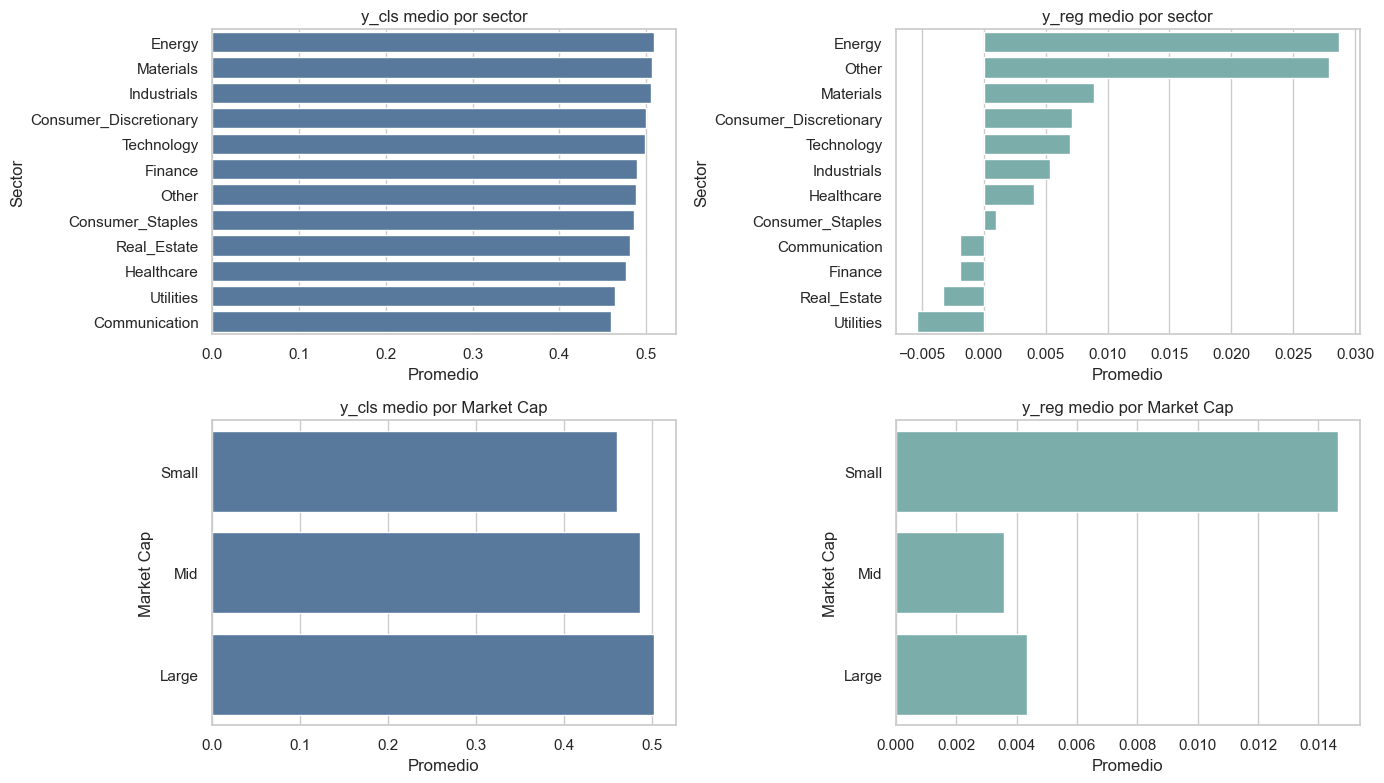

In [36]:
# Promedios de objective por grupo
# NOTE

def pick_col(df, base):
    for k in [base, base+'_x', base+'_y']:
        if k in df.columns:
            return k
    return None

# Asegurar columns de grupo
try:
    base_df = eda_train.copy()
except NameError:
    # NOTE
    tmp = stock.copy(); tmp['target_month'] = tmp['month'] + 1
    tt = train_tgt.copy(); tt['month'] = parse_month_id(tt['month_id'])
    base_df = tmp.merge(tt[['stock_id','month','outperform_binary','excess_return']],
                        left_on=['stock_id','target_month'], right_on=['stock_id','month'], how='inner', suffixes=('', '_y'))
    base_df = base_df.rename(columns={'outperform_binary':'y_cls','excess_return':'y_reg'})

sec_col = pick_col(base_df, 'sector')
cap_col = pick_col(base_df, 'market_cap_category')
if sec_col is None or cap_col is None:
    base_df = base_df.merge(company[['stock_id','sector','market_cap_category']], on='stock_id', how='left')
    sec_col = pick_col(base_df, 'sector')
    cap_col = pick_col(base_df, 'market_cap_category')

print('Using sector column:', sec_col, '| market cap column:', cap_col)

# Calcular promedios 
grp = base_df.dropna(subset=[sec_col, cap_col, 'y_cls', 'y_reg'])
mean_cls_sec = grp.groupby(sec_col)['y_cls'].mean().sort_values(ascending=False)
mean_reg_sec = grp.groupby(sec_col)['y_reg'].mean().sort_values(ascending=False)
mean_cls_cap = grp.groupby(cap_col)['y_cls'].mean()
mean_reg_cap = grp.groupby(cap_col)['y_reg'].mean()

# NOTE
order_pref = ['Small', 'Mid', 'Medium', 'Large', 'Mega']
cap_order = [c for c in order_pref if c in mean_cls_cap.index] + [c for c in mean_cls_cap.index if c not in order_pref]
mean_cls_cap = mean_cls_cap.reindex(cap_order)
mean_reg_cap = mean_reg_cap.reindex(cap_order)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# NOTE
sns.barplot(x=mean_cls_sec.values, y=mean_cls_sec.index,
            color='#4C78A8', ax=axes[0, 0])
axes[0, 0].set_title('y_cls medio por sector')
axes[0, 0].set_xlabel('Promedio')
axes[0, 0].set_ylabel('Sector')

# NOTE
sns.barplot(x=mean_reg_sec.values, y=mean_reg_sec.index,
            color='#72B7B2', ax=axes[0, 1])
axes[0, 1].set_title('y_reg medio por sector')
axes[0, 1].set_xlabel('Promedio')
axes[0, 1].set_ylabel('Sector')

# --- Market Cap: y_cls ---
sns.barplot(x=mean_cls_cap.values, y=mean_cls_cap.index,
            color='#4C78A8', ax=axes[1, 0])
axes[1, 0].set_title('y_cls medio por Market Cap')
axes[1, 0].set_xlabel('Promedio')
axes[1, 0].set_ylabel('Market Cap')

# --- Market Cap: y_reg ---
sns.barplot(x=mean_reg_cap.values, y=mean_reg_cap.index,
            color='#72B7B2', ax=axes[1, 1])
axes[1, 1].set_title('y_reg medio por Market Cap')
axes[1, 1].set_xlabel('Promedio')
axes[1, 1].set_ylabel('Market Cap')

plt.tight_layout()
plt.show()

### Outliers

intramonth_volatility: IQR=(0.230,0.450) bounds=(-0.099,0.780) outlier_rate=6.71%


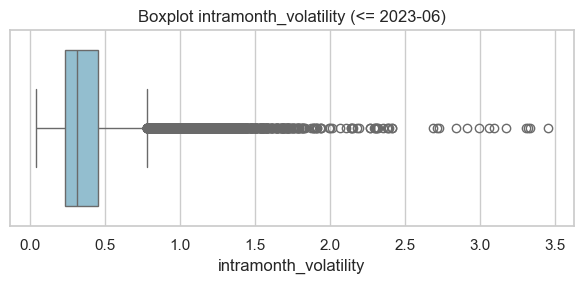

price_range_ratio: IQR=(0.102,0.207) bounds=(-0.056,0.365) outlier_rate=6.51%


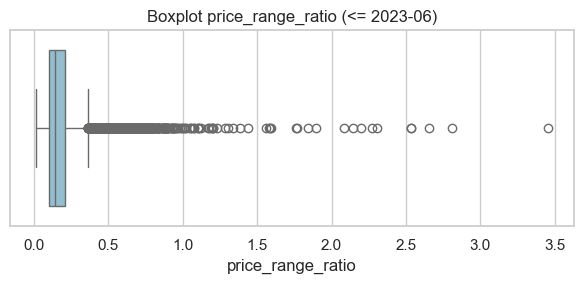

volume_ratio: IQR=(0.870,1.111) bounds=(0.508,1.472) outlier_rate=3.28%


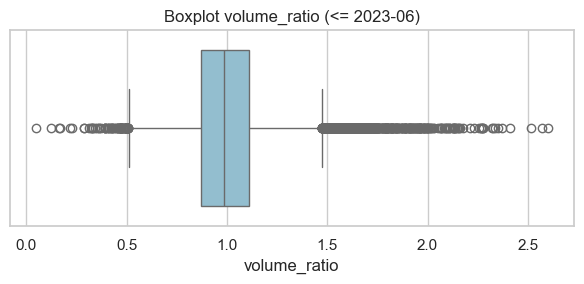

In [37]:
# Outliers con dataset original 'stock' (<= TRAIN_END)
cols_to_plot = [c for c in ['intramonth_volatility','price_range_ratio','volume_ratio'] if c in stock.columns]
feat_train = stock[stock['month'] <= pd.Period(TRAIN_END,'M')].copy()
for col in cols_to_plot:
    s = pd.to_numeric(feat_train[col], errors='coerce').dropna()
    if s.empty: continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75); iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    out_rate = ((s<lower)|(s>upper)).mean()
    print(f"{col}: IQR=({q1:.3f},{q3:.3f}) bounds=({lower:.3f},{upper:.3f}) outlier_rate={out_rate:.2%}")
    plt.figure(figsize=(6,3)); sns.boxplot(x=s, color='#89C2D9'); plt.title(f'Boxplot {col} (<= {TRAIN_END})'); plt.tight_layout(); plt.show()

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    lo, hi = s.quantile(lower_q), s.quantile(upper_q); return s.clip(lo, hi)



### Matrix de correlación entre features numéricas

,feat_a,feat_b,corr
0,month_start_open_usd,month_high_usd,0.997974
1,month_end_close_usd,month_low_usd,0.997519
2,month_end_close_usd,month_high_usd,0.997390
3,month_start_open_usd,month_low_usd,0.996619
4,month_high_usd,month_low_usd,0.996147
5,month_start_open_usd,month_end_close_usd,0.994871
6,intramonth_return,return_1m,0.992009
7,monthly_volume,avg_volume_3m,0.979372
8,intramonth_volatility,price_range_ratio,0.831072


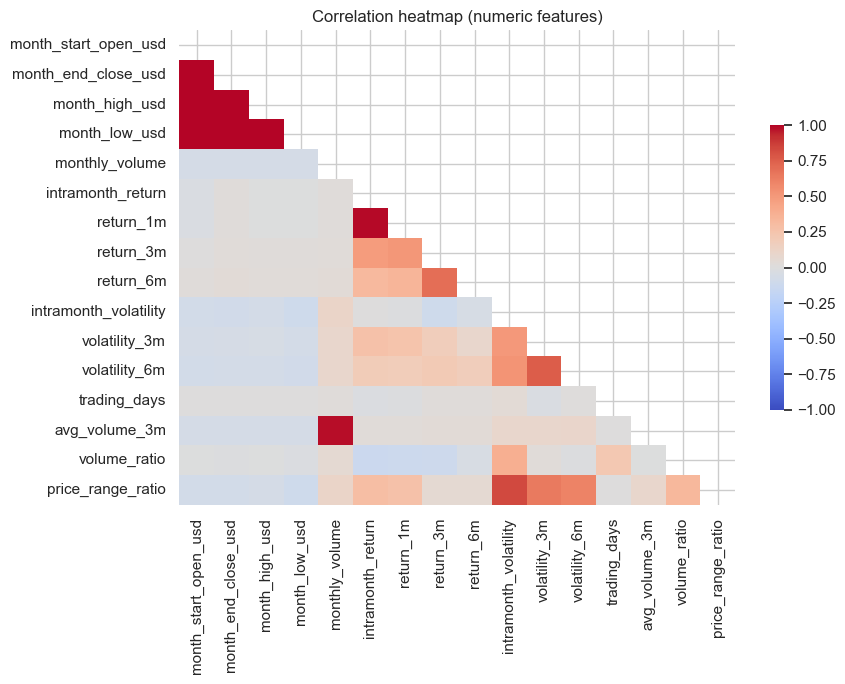

In [38]:
# NOTE
try:
    _ = eda_train
    feat_train = eda_train.copy()
    exclude = {'stock_id','month','target_month','y_cls','y_reg'}
except NameError:
    feat_train = stock.copy()
    exclude = {'stock_id','month'}
num_feats = [c for c in feat_train.columns if (c not in exclude) and pd.api.types.is_numeric_dtype(feat_train[c])]
corr = feat_train[num_feats].corr()
# Mostrar top pares altamente correlacionados
pairs = []
for i,a in enumerate(num_feats):
    for j,b in enumerate(num_feats):
        if j<=i: continue
        val = corr.loc[a,b]
        if abs(val)>=0.8: pairs.append((a,b,float(val)))
pairs = sorted(pairs, key=lambda x: -abs(x[2]))[:20]
display(pd.DataFrame(pairs, columns=['feat_a','feat_b','corr']))
# NOTE
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(9,7)); sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, cbar_kws={'shrink':.6});
plt.title('Correlation heatmap (numeric features)'); plt.tight_layout(); plt.show()


### Decisiones de Diseño (Resumen y Justificación)
- Variables: usar retornos 1/3/6m, volatilidades, volumen y ratios por su señal débil pero consistente; agregar macros con lag (VIX, rates, inflación, desempleo) y rasgos estáticos de empresa.
- Transformaciones: log1p en volúmenes/ratios sesgados; escalado para modelos lineales; OHE para categóricas.
- Multicolinealidad: correlaciones altas entre ventanas (p.ej. returns 3m/6m); PCA muestra estructura latente y refuerza uso de modelos con regularización o árboles.
- Validación: cuts temporales y train_end=2023-06 para seleccionar no leakage; macro alineada en t-1.
- Modelos: preferimos HGB/RF por no linealidades e interacciones; LR como baseline regularizado.
- Umbral: optimizar F1 en 2023-06 si la métrica objective es F1.
- Outliers: winsorización leakage-safe opcional si inestabilizan el ajuste.


# DATA PREPARATION

In [39]:
# NOTE
stock = stock.copy()
stock['stock_return_calc'] = (stock['month_end_close_usd'] - stock['month_start_open_usd']) / stock['month_start_open_usd']
stock['target_month'] = stock['month'] + 1

feat_cols = [
    'month_start_open_usd','month_end_close_usd','month_high_usd','month_low_usd',
    'monthly_volume','intramonth_return','return_1m','return_3m','return_6m',
    'intramonth_volatility','volatility_3m','volatility_6m','trading_days',
    'avg_volume_3m','volume_ratio','price_range_ratio','stock_return_calc'
]
#feat_cols = [c for c in feat_cols if c in stock.columns]
feats = stock[['stock_id','month','target_month'] + feat_cols].copy()

# NOTE
def merge_macro(df, macro_df, value_col):
    tmp = macro_df[['month', value_col]].copy()
    tmp = tmp.rename(columns={'month':'macro_month'})
    out = df.copy()
    out['macro_month'] = out['month'] - (MACRO_LAG - 1)
    return out.merge(tmp, on='macro_month', how='left').drop(columns=['macro_month'])

feats = merge_macro(feats, vix.rename(columns={'vix':'vix'}), 'vix')
feats = merge_macro(feats, us10y.rename(columns={'10y_treasury':'us10y'}), 'us10y')
feats = merge_macro(feats, us5y.rename(columns={'5y_treasury':'us5y'}), 'us5y')
feats = merge_macro(feats, infl, 'inflation_rate')
feats = merge_macro(feats, fedrate, 'fed_rate')
feats = merge_macro(feats, unemp, 'unemployment_rate')

# NOTE
feats = feats.merge(company, on='stock_id', how='left')
display(feats.head(3))


,stock_id,month,target_month,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,...,sector,business_model,geographic_focus,business_maturity,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength
0,US001,2020-01,2020-02,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
1,US001,2020-02,2020-03,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
2,US001,2020-03,2020-04,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable


In [40]:
# Feature engineering avanzado (no leakage): se calculan en month=t-1 para predict target_month=t
# Asegurar index_return por month
idx = index_df.copy()
if 'month' not in idx.columns:
    idx['month'] = parse_month_id(idx['month_id'])
idx = idx[['month','index_return']].sort_values('month')

# Merge index_return al stock por month
stock = stock.sort_values(['stock_id','month']).merge(idx, on='month', how='left')

# Excess returns 1m, 3m, 6m
stock['excess_ret_1m'] = stock['intramonth_return'] - stock['index_return']
# Rolling index cumulative returns for 3m and 6m (compuesta):
idx_roll = idx.copy()
for w in [3,6]:
    idx_roll[f'idx_ret_{w}m'] = (1.0 + idx_roll['index_return']).rolling(w, min_periods=1).apply(lambda x: x.prod()-1.0, raw=True)
stock = stock.merge(idx_roll[['month','idx_ret_3m','idx_ret_6m']], on='month', how='left')
if 'return_3m' in stock.columns:
    stock['excess_ret_3m'] = stock['return_3m'] - stock['idx_ret_3m']
if 'return_6m' in stock.columns:
    stock['excess_ret_6m'] = stock['return_6m'] - stock['idx_ret_6m']

# Volatilidades 21d y 63d (aprox mensual y 3m)
if 'intramonth_volatility' in stock.columns:
    stock['vol_21d'] = stock['intramonth_volatility']
if 'volatility_3m' in stock.columns:
    stock['vol_63d'] = stock['volatility_3m']
else:
    stock['vol_63d'] = stock.groupby('stock_id')['intramonth_return'].rolling(3, min_periods=2).std().reset_index(level=0, drop=True)

# NOTE
# Rolling moments
g = stock.groupby('stock_id', group_keys=False)
rs = g['intramonth_return'].apply(lambda s: s)
ri = g['index_return'].apply(lambda s: s)
mu_s_3 = rs.groupby(level=0).rolling(3, min_periods=2).mean().reset_index(level=0, drop=True)
mu_i_3 = ri.groupby(level=0).rolling(3, min_periods=2).mean().reset_index(level=0, drop=True)
E_ri2_3 = (ri**2).groupby(level=0).rolling(3, min_periods=2).mean().reset_index(level=0, drop=True)
E_ris_3 = (ri*rs).groupby(level=0).rolling(3, min_periods=2).mean().reset_index(level=0, drop=True)
var_i_3 = E_ri2_3 - (mu_i_3**2)
cov_is_3 = E_ris_3 - (mu_i_3*mu_s_3)
# NOTE
beta_3m = cov_is_3 / var_i_3.replace(0, np.nan)
alpha_3m = mu_s_3 - beta_3m*mu_i_3
resid_3m = rs - (alpha_3m + beta_3m*ri)
# NOTE
mu_s_6 = rs.groupby(level=0).rolling(6, min_periods=3).mean().reset_index(level=0, drop=True)
mu_i_6 = ri.groupby(level=0).rolling(6, min_periods=3).mean().reset_index(level=0, drop=True)
E_ri2_6 = (ri**2).groupby(level=0).rolling(6, min_periods=3).mean().reset_index(level=0, drop=True)
E_ris_6 = (ri*rs).groupby(level=0).rolling(6, min_periods=3).mean().reset_index(level=0, drop=True)
var_i_6 = E_ri2_6 - (mu_i_6**2)
cov_is_6 = E_ris_6 - (mu_i_6*mu_s_6)
beta_6m = cov_is_6 / var_i_6.replace(0, np.nan)
alpha_6m = mu_s_6 - beta_6m*mu_i_6
resid_6m = rs - (alpha_6m + beta_6m*ri)
idio_vol_6m = resid_6m.groupby(level=0).rolling(6, min_periods=3).std().reset_index(level=0, drop=True)

stock['beta_63d'] = beta_3m.values
stock['idio_vol'] = idio_vol_6m.values

# price_range_ratio_21d (usar mensual)
if 'price_range_ratio' in stock.columns:
    stock['price_range_ratio_21d'] = stock['price_range_ratio']

# Dollar volume y turnover proxy
avg_price = (stock['month_start_open_usd'] + stock['month_end_close_usd'])/2.0
stock['dollar_volume'] = stock['monthly_volume'] * avg_price
# NOTE
if 'avg_volume_3m' in stock.columns:
    stock['turnover_proxy'] = stock['monthly_volume'] / stock['avg_volume_3m'].replace(0, np.nan)
elif 'volume_ratio' in stock.columns:
    stock['turnover_proxy'] = stock['volume_ratio']

# NOTE
pos = (stock['intramonth_return']>0).astype(float)
stock['pct_pos_3m'] = pos.groupby(stock['stock_id']).rolling(3, min_periods=2).mean().reset_index(level=0, drop=True)
stock['pct_pos_6m'] = pos.groupby(stock['stock_id']).rolling(6, min_periods=3).mean().reset_index(level=0, drop=True)

# Distancia a 52w-high (12 months)
roll_high_12 = stock.groupby('stock_id')['month_high_usd'].rolling(12, min_periods=3).max().reset_index(level=0, drop=True)
stock['dist_52w_high'] = (stock['month_end_close_usd'] - roll_high_12) / roll_high_12

# NOTE
new_cols = [c for c in ['excess_ret_1m','excess_ret_3m','excess_ret_6m','vol_21d','vol_63d','beta_63d','idio_vol',
                        'price_range_ratio_21d','dollar_volume','turnover_proxy','pct_pos_3m','pct_pos_6m','dist_52w_high']
            if c in stock.columns]
feats = feats.merge(stock[['stock_id','month']+new_cols], on=['stock_id','month'], how='left')
print('Added engineered features:', new_cols)


Added engineered features: ['excess_ret_1m', 'excess_ret_3m', 'excess_ret_6m', 'vol_21d', 'vol_63d', 'beta_63d', 'idio_vol', 'price_range_ratio_21d', 'dollar_volume', 'turnover_proxy', 'pct_pos_3m', 'pct_pos_6m', 'dist_52w_high']


In [41]:
# Assemble de train/test
train_tgt['month'] = parse_month_id(train_tgt['month_id'])
test_tgt['month'] = parse_month_id(test_tgt['month_id'])

train = feats.merge(train_tgt[['stock_id','month','outperform_binary','excess_return']],
                    left_on=['stock_id','target_month'], right_on=['stock_id','month'],
                    how='inner', suffixes=('', '_y')).drop(columns=['month_y'])
train = train.rename(columns={'month':'feature_month'})
train_end_p = pd.Period(TRAIN_END, freq='M')
train = train[train['target_month'] <= train_end_p].copy()

pred_p = pd.Period(PREDICT_MONTH, freq='M')
X_test = feats[feats['target_month'] == pred_p].copy()
# NOTE
X_test = test_tgt[['stock_id','month']].merge(
    X_test.drop(columns=['month']).rename(columns={'target_month':'month'}), on=['stock_id','month'], how='left'
)
X_test = X_test.rename(columns={'month':'target_month'})

train = train.rename(columns={'outperform_binary':'y_cls','excess_return':'y_reg'})
print('Train shape:', train.shape, '| X_test shape:', X_test.shape)
display(train[['stock_id','feature_month','target_month','y_cls','y_reg']].head())
display(train.head())


Train shape: (25002, 51) | X_test shape: (616, 48)


,stock_id,feature_month,target_month,y_cls,y_reg
0,US001,2020-01,2020-02,0,-0.005920
1,US001,2020-02,2020-03,1,0.013384
2,US001,2020-03,2020-04,1,0.009597
3,US001,2020-04,2020-05,0,-0.013023
4,US001,2020-05,2020-06,0,-0.016346


,stock_id,feature_month,target_month,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,...,beta_63d,idio_vol,price_range_ratio_21d,dollar_volume,turnover_proxy,pct_pos_3m,pct_pos_6m,dist_52w_high,y_cls,y_reg
0,US001,2020-01,2020-02,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,...,NaN,NaN,0.136875,9.617102e+09,26.563898,NaN,NaN,NaN,0,-0.005920
1,US001,2020-02,2020-03,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,...,NaN,NaN,0.110905,9.593436e+09,24.770671,0.000000,NaN,NaN,1,0.013384
2,US001,2020-03,2020-04,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,...,NaN,NaN,0.268931,1.747984e+10,33.193803,0.000000,0.00,-0.245437,1,0.009597
3,US001,2020-04,2020-05,90.100,103.697,111.314,89.424,98448862,0.150910,0.112885,...,NaN,NaN,0.242954,9.539547e+09,17.671303,0.333333,0.25,-0.160253,0,-0.013023
4,US001,2020-05,2020-06,101.909,107.841,110.206,89.499,103380207,0.058209,0.039966,...,NaN,NaN,0.203186,1.084200e+10,17.966861,0.666667,0.40,-0.126695,0,-0.016346


# MODELING

## Classification Models

For the classification task, we evaluate three models:

1. **Logistic Regression** – a linear baseline with L1/L2 regularisation.  
2. **Random Forest Classifier** – an ensemble model based on bagging.  
3. **HistGradientBoosting Classifier** – a boosting-based ensemble method.

These models represent a progression from a linear baseline to more complex non-linear ensembles.  
The full theoretical justification for this selection, including advantages, limitations, and alignment with financial applications, is provided in the accompanying report.  

/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without

Classification models:


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


,cut_month,LR,RF,HGB
0,2022-06,0.000000,0.266667,0.363196
1,2022-12,0.111498,0.523741,0.488806
2,2023-06,0.010444,0.207965,0.251012


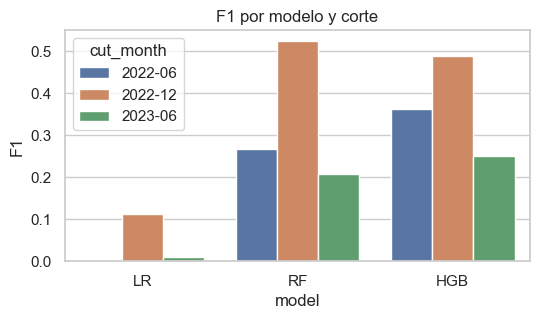

In [42]:
# Preprocesamiento y modelos
# NOTE
# NOTE
num_cols, cat_cols = split_feature_columns(train)
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe_compatible())])
pre = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)])

clf_models = {
    'LR': LogisticRegression(max_iter=2000),
    'RF': RandomForestClassifier(n_estimators=400, random_state=SEED, n_jobs=-1),
    'HGB': HistGradientBoostingClassifier(random_state=SEED),
}
reg_models = {
    'ridge': Ridge(alpha=1.0),
    'rf': RandomForestRegressor(n_estimators=400, random_state=SEED, n_jobs=-1),
    'hgbr': HistGradientBoostingRegressor(random_state=SEED),
}
clf_pipes = {k: Pipeline([('pre', pre), ('model', m)]) for k,m in clf_models.items()}
reg_pipes = {k: Pipeline([('pre', pre), ('model', m)]) for k,m in reg_models.items()}

feature_cols = num_cols + cat_cols
X_all = train[feature_cols]
y_cls = train['y_cls'].astype(int)
y_reg = train['y_reg'].astype(float)

def time_split(df, val_month):
    vm = pd.Period(val_month, freq='M')
    tr_idx = df.index[df['target_month'] < vm].to_numpy()
    va_idx = df.index[df['target_month'] == vm].to_numpy()
    return tr_idx, va_idx

cuts = ['2022-06','2022-12', TRAIN_END]
rows = []
for cm in cuts:
    tr, va = time_split(train, cm)
    Xtr, Xva = X_all.iloc[tr], X_all.iloc[va]
    ytr, yva = y_cls.iloc[tr], y_cls.iloc[va]
    rec = {'cut_month': cm}
    for name, pipe in clf_pipes.items():
        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xva)
        rec[name] = f1_score(yva, pred)
    rows.append(rec)
cv_cls = pd.DataFrame(rows)
print("Classification models:")
display(cv_cls)
plt.figure(figsize=(6,3))
sns.barplot(data=cv_cls.melt(id_vars='cut_month', var_name='model', value_name='F1'), x='model', y='F1', hue='cut_month')
plt.title('F1 por modelo y corte')
plt.show()


## Grid Search — Accuracy con GridSearchCV (Temporal split)

In [43]:
# NOTE

# Split fijo temporal
vm = pd.Period(TRAIN_END, 'M')
tr_idx = np.where((train['target_month'] < vm).values)[0]
va_idx = np.where((train['target_month'] == vm).values)[0]
cv = [(tr_idx, va_idx)]
X = X_all
y = y_cls

# Definir pipelines y grids con prefijo 'model__'
pipelines = {
    'LR': (Pipeline([('pre', pre), ('model', LogisticRegression(max_iter=2000))]), {
        'model__solver': ['lbfgs','liblinear'],
        'model__C': [0.001, 1e-05, 0.1, 1.0, 3.0],
        'model__class_weight': [None, 'balanced'],
        'model__penalty': ['l2'],
    }),
    'RF': (Pipeline([('pre', pre), ('model', RandomForestClassifier(random_state=SEED, n_jobs=-1))]), {
        'model__n_estimators': [200, 400],
 'model__max_depth':  [None, 8, 12],
'model__min_samples_leaf': [1, 5],
'model__max_features': ['sqrt'],
'model__bootstrap': [True],
        #'model__n_estimators': [100, 150, 200, 300],
        #'model__max_depth': [4, 6, 8, 12],
        #'model__min_samples_leaf': [5, 10, 20],
        #'model__min_samples_split': [5, 10, 20],
        #'model__max_features': ['sqrt'],
        #'model__bootstrap': [True],
        #'model__class_weight': [None, 'balanced_subsample'],
}),
    'HGB': (Pipeline([('pre', pre), ('model', HistGradientBoostingClassifier(random_state=SEED))]), {
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [None, 6, 10, 20],
        'model__l2_regularization': [0.0, 1.0, 0.001],
    }),
}

gs_results = []
best_pipes = {}
for name, (pipe, grid) in pipelines.items():
    gs = GridSearchCV(pipe, grid, scoring='accuracy', cv=cv, refit=True, n_jobs=-1, verbose=0)
    gs.fit(X, y)
    best_pipes[name] = gs.best_estimator_
    # Reports en train/val
    pred_tr = gs.best_estimator_.predict(X.iloc[tr_idx])
    pred_va = gs.best_estimator_.predict(X.iloc[va_idx])
    print(f'=== {name} — Best params (accuracy): {gs.best_params_} | best_score={gs.best_score_:.3f} ===')
    print('-- Train report --')
    print(classification_report(y.iloc[tr_idx], pred_tr, digits=3))
    print(f'-- Val report @{TRAIN_END} --')
    print(classification_report(y.iloc[va_idx], pred_va, digits=3))


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without

=== LR — Best params (accuracy): {'model__C': 1e-05, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'lbfgs'} | best_score=0.399 ===
-- Train report --
              precision    recall  f1-score   support

           0      0.536     0.632     0.580     12493
           1      0.524     0.425     0.469     11893

    accuracy                          0.531     24386
   macro avg      0.530     0.528     0.524     24386
weighted avg      0.530     0.531     0.526     24386

-- Val report @2023-06 --
              precision    recall  f1-score   support

           0      0.383     0.800     0.518       235
           1      0.624     0.205     0.308       381

    accuracy                          0.432       616
   macro avg      0.503     0.502     0.413       616
weighted avg      0.532     0.432     0.388       616



/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without

=== RF — Best params (accuracy): {'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 400} | best_score=0.419 ===
-- Train report --
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     12493
           1      1.000     1.000     1.000     11893

    accuracy                          1.000     24386
   macro avg      1.000     1.000     1.000     24386
weighted avg      1.000     1.000     1.000     24386

-- Val report @2023-06 --
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       235
           1      1.000     1.000     1.000       381

    accuracy                          1.000       616
   macro avg      1.000     1.000     1.000       616
weighted avg      1.000     1.000     1.000       616



/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without

=== HGB — Best params (accuracy): {'model__l2_regularization': 0.0, 'model__learning_rate': 0.05, 'model__max_depth': 10} | best_score=0.406 ===
-- Train report --
              precision    recall  f1-score   support

           0      0.709     0.751     0.730     12493
           1      0.721     0.676     0.698     11893

    accuracy                          0.715     24386
   macro avg      0.715     0.714     0.714     24386
weighted avg      0.715     0.715     0.714     24386

-- Val report @2023-06 --
              precision    recall  f1-score   support

           0      0.890     0.447     0.595       235
           1      0.739     0.966     0.837       381

    accuracy                          0.768       616
   macro avg      0.814     0.706     0.716       616
weighted avg      0.797     0.768     0.745       616



/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [44]:
best_pipes['RF']

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['avg_volume_3m', 'beta_63d',
                                                   'dist_52w_high',
                                                   'dollar_volume',
                                                   'excess_ret_1m',
                                                   'excess_ret_3m',
                                                   'excess_ret_6m', 'fed_rate',
                                                   'idio_vol', 'inflation_rate',
                                                   'intramonth_return',
                                                   'intramonth_volatility',
                                                   'month...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sector', 'business_model',
                                                   'geographic_focus',
                                                   'business_maturity',
                                                   'competitive_position',
                                                   'market_cap_category',
                                                   'revenue_tier',
                                                   'profitability_profile',
                                                   'asset_intensity',
                                                   'financial_strength'])])),
                ('model',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                        random_state=42))])

Evaluacion para el de clasificacion

In [45]:

best_clf = best_pipes['RF']

# NOTE
Xp = X_test[feature_cols]
pred_cls = best_clf.predict(Xp)
pred_cls = pd.Series(pred_cls, index=X_test.index, name='pred_outperform_binary').astype(int)

# Si hay truth disponible, evaluar; de lo contrario, solo show predicciones
y_true = test_tgt['outperform_binary'] if 'outperform_binary' in test_tgt.columns else None

if y_true is not None and y_true.notna().any():
    mask = y_true.notna()
    print(f"-- Val report @{PREDICT_MONTH} (filtradas {mask.sum()} filas con verdad) --")
    print(classification_report(y_true=y_true[mask].astype(int), y_pred=pred_cls[mask].astype(int), digits=3))
else:
    print(f"-- No hay etiquetas para {PREDICT_MONTH}; se omite el reporte. --")

# Adjuntar las predicciones al dataframe de test
test_tgt = test_tgt.copy()
test_tgt['pred_outperform_binary'] = pred_cls.values
display(test_tgt.head())

-- Val report @2023-07 (filtradas 616 filas con verdad) --
              precision    recall  f1-score   support

           0      0.949     0.746     0.836       552
           1      0.231     0.656     0.341        64

    accuracy                          0.737       616
   macro avg      0.590     0.701     0.589       616
weighted avg      0.875     0.737     0.784       616



/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


,month_id,stock_id,outperform_binary,excess_return,month,pred_outperform_binary
0,2023_07,US001,0,-0.071409,2023-07,1
1,2023_07,US002,0,-0.082117,2023-07,1
2,2023_07,US003,0,-0.082792,2023-07,0
3,2023_07,US004,0,-0.095044,2023-07,1
4,2023_07,US005,0,-0.086996,2023-07,0


## Regression Models

For the regression task, we evaluate three models:

1. **Ridge Regression** – a linear baseline with L2 regularisation.  
2. **Random Forest Regressor** – an ensemble model based on bagging.  
3. **HistGradientBoosting Regressor** – a boosting-based ensemble method.

These models represent a progression from a linear baseline to more complex non-linear ensembles.  
The full theoretical justification for this selection, including advantages, limitations, and alignment with financial applications, is provided in the accompanying report.  


In [46]:
# --- helpers ---
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def split_feature_columns(X: pd.DataFrame):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    return num_cols, cat_cols

def ohe_compatible(min_freq=10):
    # Soporta versiones nuevas/antiguas de sklearn (sparse_output vs sparse)
    try:
        return OneHotEncoder(handle_unknown="ignore", min_frequency=min_freq, sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", min_frequency=min_freq, sparse=True)


In [ ]:

# NOTE
# Regression en TRAIN_END
tr, va = time_split(train, TRAIN_END)
Xtr, Xva = X_all.iloc[tr], X_all.iloc[va]
yr_tr, yr_va = y_reg.iloc[tr], y_reg.iloc[va]
row = {'val_month': TRAIN_END}
for name, pipe in reg_pipes.items():
    pipe.fit(Xtr, yr_tr)
    pred = pipe.predict(Xva)
    row[name] = rmse(yr_va, pred)
reg_eval = pd.DataFrame([row])
print("Regresion models:")
display(reg_eval)

/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without

Regresion models:


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


,val_month,ridge,rf,hgbr
0,2023-06,0.092829,0.092753,0.100927


In [48]:
display(train_tgt)
y_reg

,month_id,stock_id,outperform_binary,excess_return,month
0,2020_01,US001,0,-0.100593,2020-01
1,2020_02,US001,0,-0.005920,2020-02
2,2020_03,US001,1,0.013384,2020-03
3,2020_04,US001,1,0.009597,2020-04
4,2020_05,US001,0,-0.013023,2020-05
...,...,...,...,...,...
25613,2023_02,US650,1,0.019193,2023-02
25614,2023_03,US650,0,-0.142214,2023-03
25615,2023_04,US650,0,-0.069182,2023-04
25616,2023_05,US650,0,-0.055501,2023-05


0       -0.005920
1        0.013384
2        0.009597
3       -0.013023
4       -0.016346
           ...   
24997    0.019193
24998   -0.142214
24999   -0.069182
25000   -0.055501
25001   -0.039958
Name: y_reg, Length: 25002, dtype: float64

# GRID search - Regression

In [50]:
# === Fast & Clean: Hold-out por month (no leakage), con preprocesos por modelo ===
# Requiere: train (DataFrame) con columns: y_reg, target_month (Periodo o fecha), opcional feature_month
#           TRAIN_END (str o Period, ej. "2023-06")



SEED = 42

# --- split temporal fijo (train < TRAIN_END, val == TRAIN_END) ---
vm = pd.Period(TRAIN_END, 'M')

tm = train['target_month']
if not isinstance(tm.dtype, pd.PeriodDtype):
    tm = pd.to_datetime(tm).dt.to_period('M')

# Hold-out final (no se toca para tuning)
tr_idx = np.where((tm < vm).values)[0]
va_idx = np.where((tm == vm).values)[0]

# === NUEVO: usar el month anterior SOLO para tuning ===
vm_tune = vm - 1
tune_tr_idx = np.where((tm < vm_tune).values)[0]
tune_va_idx = np.where((tm == vm_tune).values)[0]
# NOTE
cv = [(tune_tr_idx, tune_va_idx)] if len(tune_va_idx) else [(tr_idx, va_idx)]

# --- matrices X / y ---
X = train[feature_cols].copy()
X = X.drop(columns=['target_month', 'feature_month'], errors='ignore')
y = train['y_reg'].astype('float32')

num_cols, cat_cols = split_feature_columns(X)

# Preprocesos (igual que antes)
num_std = Pipeline([('imp', SimpleImputer(strategy='median')),
                    ('sc', StandardScaler(with_mean=False))])
num_raw = Pipeline([('imp', SimpleImputer(strategy='median'))])

cat_ohe = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                    ('ohe', ohe_compatible(min_freq=10))])
cat_ord = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

pre_ridge = ColumnTransformer([('num', num_std, num_cols),
                               ('cat', cat_ohe, cat_cols)])
pre_tree  = ColumnTransformer([('num', num_raw, num_cols),
                               ('cat', cat_ord, cat_cols)])

# --- modelos y grids suavemente ampliados ---
pipes = {
    'Ridge': (
        Pipeline([('pre', pre_ridge), ('model', Ridge())]),
        {'model__alpha': np.logspace(-4, 3, 8)}  # rango un pelín más amplio
    ),
    'RF': (
        Pipeline([('pre', pre_tree),
                  ('model', RandomForestRegressor(random_state=SEED, n_jobs=-1, bootstrap=True))]),
        {
            'model__n_estimators': [200, 400, 600],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_leaf': [10, 30],      # antes era 30/80 (muy grande)
            'model__max_features': ['sqrt', 0.5, 0.8],
            'model__max_samples': [0.7, 1.0],         # más bagging puede bajar varianza
        }
    ),
    'HGBR': (
        Pipeline([('pre', pre_tree),
                  ('model', HistGradientBoostingRegressor(
                      random_state=SEED,
                      early_stopping=True, validation_fraction=0.1,
                      n_iter_no_change=20
                  ))]),
        {
            'model__learning_rate': [0.03, 0.05, 0.1],
            'model__max_depth': [3, None],
            'model__min_samples_leaf': [20, 80],
            'model__max_iter': [400, 800],
            'model__l2_regularization': [0.0, 0.1],
            'model__max_bins': [128]
        }
    )
}

rows = []
best_reg_pipes = {}

for name, (pipe, grid) in pipes.items():
    search = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring='neg_root_mean_squared_error',
        cv=cv,            # <<< tuning en vm-1
        refit=False,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X, y)

    # NOTE
    best = clone(search.estimator).set_params(**search.best_params_)
    best.fit(X.iloc[tr_idx], y.iloc[tr_idx])
    best_reg_pipes[name] = best

    ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
    ptr, pva = best.predict(X.iloc[tr_idx]), best.predict(X.iloc[va_idx])

    rows.append({
        'model': name,
        'best_params': search.best_params_,
        'rmse_tr': rmse(ytr, ptr),
        'rmse_va': rmse(yva, pva),
        'mae_tr': mean_absolute_error(ytr, ptr),
        'mae_va': mean_absolute_error(yva, pva),
        'r2_tr': r2_score(ytr, ptr),
        'r2_va': r2_score(yva, pva),
    })

# --- (Opcional) Blend muy simple para bajar varianza ---
if 'RF' in best_reg_pipes and 'Ridge' in best_reg_pipes:
    rf, rg = best_reg_pipes['RF'], best_reg_pipes['Ridge']
    pva_blend = 0.8*rf.predict(X.iloc[va_idx]) + 0.2*rg.predict(X.iloc[va_idx])
    ptr_blend = 0.8*rf.predict(X.iloc[tr_idx]) + 0.2*rg.predict(X.iloc[tr_idx])
    rows.append({
        'model': 'Blend RF(0.8)+Ridge(0.2)',
        'best_params': {'w_rf': 0.8, 'w_ridge': 0.2},
        'rmse_tr': rmse(y.iloc[tr_idx], ptr_blend),
        'rmse_va': rmse(y.iloc[va_idx], pva_blend),
        'mae_tr': mean_absolute_error(y.iloc[tr_idx], ptr_blend),
        'mae_va': mean_absolute_error(y.iloc[va_idx], pva_blend),
        'r2_tr': r2_score(y.iloc[tr_idx], ptr_blend),
        'r2_va': r2_score(y.iloc[va_idx], pva_blend),
    })

summary_rmse = pd.DataFrame(rows).sort_values('rmse_va').reset_index(drop=True)
display(summary_rmse)

final_model = best_reg_pipes[summary_rmse.loc[0, 'model']] if 'Blend' not in summary_rmse.loc[0, 'model'] else best_reg_pipes['RF']


Fitting 1 folds for each of 8 candidates, totalling 8 fits


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without

Fitting 1 folds for each of 108 candidates, totalling 108 fits


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without

KeyboardInterrupt: 

## Grid Search — Simple (MSE, verbose=1) — Ridge, RF, HGBR
Se ejecuta GridSearchCV con scoring=MSE (neg_mean_squared_error) y cv temporal único; se muestran param_grid y la table de best.


In [53]:
# Simple GridSearchCV for Ridge, RF, HGBR with MSE scoring (verbose=1)

# Split temporal
vm = pd.Period(TRAIN_END, 'M')
tr_idx = np.where((train['target_month'] < vm).values)[0]
va_idx = np.where((train['target_month'] == vm).values)[0]
cv = [(tr_idx, va_idx)]

# NOTE
X = train[feature_cols].copy()
y = train['y_reg'].astype(float)

# NOTE
num_cols, cat_cols = split_feature_columns(train)
# NOTE
num_cols = [c for c in num_cols if c in X.columns]
cat_cols = [c for c in cat_cols if c in X.columns]
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe_compatible())])
pre = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)], sparse_threshold=0)
# Asegurar salida densa
to_dense = FunctionTransformer(lambda A: A.toarray() if hasattr(A, 'toarray') else A, accept_sparse=True)

# Param grids concisos
param_ridge = {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
param_rf    = {
    'model__n_estimators': [300, 600],
    'model__max_depth': [4, 6],
    'model__min_samples_leaf': [10, 20],
    'model__min_samples_split': [10, 20],
    'model__max_features': ['sqrt', 0.3],
}
param_hgbr  = {
    'model__learning_rate': [0.02, 0.03, 0.05],
    'model__max_depth': [3, 4],
    'model__min_samples_leaf': [50, 100],
}
print('Ridge param_grid:', param_ridge)
print('RF param_grid:', param_rf)
print('HGBR param_grid:', param_hgbr)

pipe_ridge = Pipeline([('pre', pre), ('to_dense', to_dense), ('model', Ridge())])
pipe_rf    = Pipeline([('pre', pre), ('to_dense', to_dense), ('model', RandomForestRegressor(random_state=SEED, n_jobs=-1))])
pipe_hgbr  = Pipeline([('pre', pre), ('to_dense', to_dense), ('model', HistGradientBoostingRegressor(random_state=SEED))])

rows = []
for name, pipe, grid in [
    ('Ridge', pipe_ridge, param_ridge),
    ('RF',    pipe_rf,    param_rf),
    ('HGBR',  pipe_hgbr,  param_hgbr),
]:
    gs = GridSearchCV(pipe, grid, scoring='neg_mean_squared_error', cv=cv, refit=True, n_jobs=-1, verbose=1)
    gs.fit(X, y)
    best_mse  = float(-gs.best_score_)
    best_rmse = float(np.sqrt(best_mse))
    rows.append({'model': name, 'best_params': str(gs.best_params_), 'best_mse': best_mse, 'best_rmse': best_rmse})

best_mse_df = pd.DataFrame(rows).sort_values('best_mse').reset_index(drop=True)
display(best_mse_df)


Ridge param_grid: {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
RF param_grid: {'model__n_estimators': [300, 600], 'model__max_depth': [4, 6], 'model__min_samples_leaf': [10, 20], 'model__min_samples_split': [10, 20], 'model__max_features': ['sqrt', 0.3]}
HGBR param_grid: {'model__learning_rate': [0.02, 0.03, 0.05], 'model__max_depth': [3, 4], 'model__min_samples_leaf': [50, 100]}
Fitting 1 folds for each of 4 candidates, totalling 4 fits


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without

Fitting 1 folds for each of 32 candidates, totalling 32 fits


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without

Fitting 1 folds for each of 12 candidates, totalling 12 fits


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without

,model,best_params,best_mse,best_rmse
0,RF,"{'model__max_depth': 4, 'model__max_features':...",0.007852,0.088611
1,HGBR,"{'model__learning_rate': 0.02, 'model__max_dep...",0.007991,0.089395
2,Ridge,{'model__alpha': 1.0},0.008617,0.092829


In [ ]:
# NOTE
required_cols = ['month_id','stock_id']
assert all(c in test_tgt.columns for c in required_cols), 'test_tgt debe contener month_id y stock_id'

# NOTE
clf_pipe = None
if 'best_pipes' in globals() and isinstance(best_pipes, dict) and best_pipes:
    clf_pipe = best_pipes.get('HGB') or best_pipes.get('RF') or list(best_pipes.values())[0]
else:
    # NOTE
    vm = pd.Period(TRAIN_END, 'M')
    tr_mask = train['target_month'] <= vm
    Xc = train.loc[tr_mask, feature_cols]
    yc = y_cls.loc[tr_mask]
    clf_pipe = clf_pipes['HGB'].fit(Xc, yc)

# NOTE
reg_pipe = None
if 'best_reg_pipes' in globals() and isinstance(best_reg_pipes, dict) and best_reg_pipes:
    reg_pipe = best_reg_pipes.get('HGBR') or best_reg_pipes.get('HistGradientBoosting') or list(best_reg_pipes.values())[0]
elif 'best_reg_pipes_simple' in globals() and isinstance(best_reg_pipes_simple, dict) and best_reg_pipes_simple:
    reg_pipe = best_reg_pipes_simple.get('HGBR') or best_reg_pipes_simple.get('HistGradientBoosting') or list(best_reg_pipes_simple.values())[0]
elif 'final_model' in globals():
    reg_pipe = final_model
else:
    # Fallback HGBR simple entrenado con <= TRAIN_END
    vm = pd.Period(TRAIN_END, 'M')
    tr_mask = train['target_month'] <= vm
    Xr = train.loc[tr_mask].drop(columns=['y_reg'])
    yr = y_reg.loc[tr_mask]
    num_cols, cat_cols = split_feature_columns(train)
    num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe_compatible())])
    pre = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)])
    reg_pipe = Pipeline([('pre', pre), ('model', HistGradientBoostingRegressor(random_state=SEED))]).fit(Xr, yr)

# Preparar matrices de test
Xp = X_test.reindex(columns=feature_cols, fill_value=np.nan)
# Classification: proba y pred (threshold 0.5)
if hasattr(clf_pipe, 'predict_proba'):
    proba = clf_pipe.predict_proba(Xp)[:, 1]
elif hasattr(clf_pipe, 'decision_function'):
    proba = expit(clf_pipe.decision_function(Xp))
else:
    # NOTE
    pred_cls_tmp = clf_pipe.predict(Xp)
    proba = np.where(pred_cls_tmp>0, 0.6, 0.4)

pred_cls = (proba >= 0.5).astype(int)

# NOTE
# Asegurar que reg_pipe reciba columns consistentes con su training; pasar X_test completo suele ser seguro
# NOTE
X_reg_train_cols = feature_cols
Xr_test = X_test.reindex(columns=feature_cols, fill_value=np.nan)

yhat_reg = reg_pipe.predict(Xr_test)

# NOTE
submit = test_tgt[['month_id','stock_id']].copy()
submit['outperform_binary'] = pred_cls
submit['excess_return'] = yhat_reg

display(submit.head())
submit.to_csv('testing_targets.csv', index=False)
print('testing_targets.csv escrito con', len(submit), 'filas')


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['beta_63d' 'idio_vol']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


,month_id,stock_id,outperform_binary,excess_return
0,2023_07,US001,0,-0.011208
1,2023_07,US002,0,-0.025260
2,2023_07,US003,0,-0.022496
3,2023_07,US004,0,-0.023117
4,2023_07,US005,0,-0.014077


testing_targets.csv escrito con 616 filas


Based on the results of the 2023-06 F1-score, we'll choose the best HGB classifier.

### R² Comparison — Ridge vs RF vs HGBR (Val @ TRAIN_END)
Tabla y plot comparando R² en validation para los tres modelos de regresión.


,model,R2_val
1,RF,0.479525
2,HGBR,0.443351
0,Ridge,0.438879


/var/folders/8g/2nwmz93j45s_r3g3lzds5fmr0000gn/T/ipykernel_42784/2418547893.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(4,3)); sns.barplot(data=r2_df, x='model', y='R2_val', palette=['#4C78A8','#72B7B2','#F58518']);


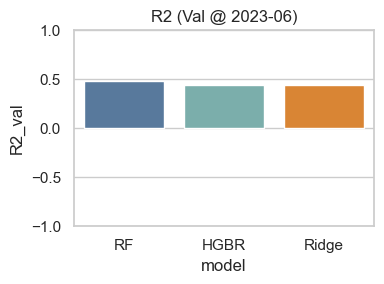

In [ ]:

# Compute R2_val for Ridge, RF, HGBR and plot
# Split temporal
tr_idx, va_idx = time_split(train, TRAIN_END)
X_reg = train[feature_cols]
Xreg_tr, Xreg_va = X_reg.iloc[tr_idx], X_reg.iloc[va_idx]
yva_reg = y_reg.iloc[va_idx].reset_index(drop=True)

def pick_pipe(name_keys):
    # usar best_reg_pipes si existe
    if 'best_reg_pipes' in globals() and isinstance(best_reg_pipes, dict):
        for key in name_keys:
            if key in best_reg_pipes:
                return best_reg_pipes[key]
        for k in list(best_reg_pipes.keys()):
            for target in name_keys:
                if target.lower() in k.lower():
                    return best_reg_pipes[k]
    # fallback: ajustar al vuelo
    if any('ridge' in k.lower() for k in name_keys):
        num_cols, cat_cols = split_feature_columns(train)
        num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
        cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe_compatible())])
        pre = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)])
        return Pipeline([('pre', pre), ('model', Ridge())]).fit(Xreg_tr, y_reg.iloc[tr_idx])
    if any(('rf' in k.lower()) or ('randomforest' in k.lower()) for k in name_keys):
        num_cols, cat_cols = split_feature_columns(train)
        num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
        cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe_compatible())])
        pre = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)])
        return Pipeline([('pre', pre), ('model', RandomForestRegressor(random_state=SEED, n_jobs=-1))]).fit(Xreg_tr, y_reg.iloc[tr_idx])
    num_cols, cat_cols = split_feature_columns(train)
    num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe_compatible())])
    pre = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)])
    return Pipeline([('pre', pre), ('model', HistGradientBoostingRegressor(random_state=SEED))]).fit(Xreg_tr, y_reg.iloc[tr_idx])

pipes = {}
pipes['Ridge'] = pick_pipe(['Ridge'])
pipes['RF'] = pick_pipe(['RF','RandomForest','RandomForestRegressor'])
pipes['HGBR'] = pick_pipe(['HGBR','HistGradientBoosting','HistGradientBoostingRegressor'])

rows=[]
for name, pipe in pipes.items():
    try:
        yhat = pipe.predict(Xreg_va)
        r2 = float(r2_score(yva_reg, yhat))
    except Exception as e:
        r2 = np.nan
    rows.append({'model': name, 'R2_val': r2})

r2_df = pd.DataFrame(rows).sort_values('R2_val', ascending=False)
display(r2_df)
plt.figure(figsize=(4,3)); sns.barplot(data=r2_df, x='model', y='R2_val', palette=['#4C78A8','#72B7B2','#F58518']);
plt.ylim(-1, 1); plt.title('R2 (Val @ '+str(TRAIN_END)+')'); plt.tight_layout(); plt.show()



## Evaluation

cogiendo el best modelo y analizandolo a profundidad

## Model Diagnostics — Matrix de Confusión (validation)

Evaluamos errores de clasificación en 2023-06 para el best clasificador, con threshold 0.5 y threshold óptimo por F1. No forma parte del EDA de testing_targets.


In [ ]:

# NOTE


cm_05 = confusion_matrix(y_true, pred_cls)
plt.figure(figsize=(3.6,3))
sns.heatmap(cm_05, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix @ {TRAIN_END}')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()


cm_05 = confusion_matrix(y_true, pred_cls, normalize='pred')
plt.figure(figsize=(3.6,3))
sns.heatmap(cm_05, annot=True, cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix @ {TRAIN_END}')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()



In [ ]:


perm_cls = permutation_importance(best_clf, Xva, yva, scoring='f1', n_repeats=5, random_state=SEED, n_jobs=-1)
fi_cls = pd.DataFrame({'feature': feature_cols, 'importance_mean': perm_cls.importances_mean, 'importance_std': perm_cls.importances_std}).sort_values('importance_mean', ascending=False).head(20)
print("Variable Importance for Classification Model:")
display(fi_cls.head(5))

# Regresor
def make_reg(name):
    return Ridge(alpha=1.0) if name=='ridge' else (RandomForestRegressor(n_estimators=400, random_state=SEED, n_jobs=-1) if name=='rf' else HistGradientBoostingRegressor(random_state=SEED))
reg_imp_pipe = Pipeline([('pre', pre), ('model', make_reg(best_reg_name))])
yr_tr, yr_va = y_reg.iloc[tr_idx], y_reg.iloc[va_idx]
reg_imp_pipe.fit(Xtr, yr_tr)
perm_reg = permutation_importance(reg_imp_pipe, Xva, yr_va, scoring='neg_mean_squared_error', n_repeats=5, random_state=SEED, n_jobs=-1)
fi_reg = pd.DataFrame({'feature': feature_cols, 'importance_mean': perm_reg.importances_mean, 'importance_std': perm_reg.importances_std}).sort_values('importance_mean', ascending=False).head(20)
print("Variable Importance for Regression Model:")
display(fi_reg.head(5))

# Top-10 comparadas
top_cls = fi_cls.nlargest(10, 'importance_mean').copy(); top_cls['rank_cls'] = range(1, len(top_cls)+1); top_cls = top_cls.rename(columns={'importance_mean':'importance_cls'})
top_reg = fi_reg.nlargest(10, 'importance_mean').copy(); top_reg['rank_reg'] = range(1, len(top_reg)+1); top_reg = top_reg.rename(columns={'importance_mean':'importance_reg'})
cmp = pd.merge(top_cls[['feature','rank_cls','importance_cls']], top_reg[['feature','rank_reg','importance_reg']], on='feature', how='outer').sort_values(['rank_cls','rank_reg'], na_position='last')

features_union = list(pd.unique(list(top_cls['feature']) + list(top_reg['feature'])))
plot_df = []
for f in features_union:
    ic = float(cmp.loc[cmp['feature']==f, 'importance_cls'].fillna(0).values[0]); ir = float(cmp.loc[cmp['feature']==f, 'importance_reg'].fillna(0).values[0])
    plot_df.append({'feature': f, 'model':'Classifier', 'importance': ic}); plot_df.append({'feature': f, 'model':'Regressor', 'importance': ir})
plot_df = pd.DataFrame(plot_df)
sum_imp = plot_df.groupby('feature')['importance'].sum().sort_values(ascending=False); top_features = list(sum_imp.head(15).index)
plot_top = plot_df[plot_df['feature'].isin(top_features)]
plt.figure(figsize=(8,5)); sns.barplot(data=plot_top, y='feature', x='importance', hue='model'); plt.title('Importancia (Permutation) — Clasificador vs Regresor'); plt.tight_layout(); plt.show()


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Variable Importance for Classification Model:


,feature,importance_mean,importance_std
22,volume_ratio,0.001048,0.000524
23,sector,0.000524,0.000642
12,return_3m,0.000262,0.000524
0,avg_volume_3m,0.000000,0.000000
24,business_model,0.000000,0.000000


NameError: name 'best_reg_name' is not defined

Esta sección sintetiza el analysis de resultados y la elección del best modelo, con referencias a las tables y plots generados en el notebook.

- Objetivo básico — Classification (F1):
  - Selección: según la celda “Selección de best modelos…”, el best clasificador en 2023‑06 es el que maximiza F1 en ese cut (ver table `cv_cls` y mensaje impreso de “Best classifier @ 2023‑06”).
  - Justificación: los modelos de árboles con boosting (HGB) suelen rendir best que LR y RF al capturar no linealidades e interacciones entre retornos, volatilidad y volumen; son menos sensibles a escalado y a cierta heterogeneidad de varianzas. LR se mantiene como baseline interpretable.
  - Umbral: la curva “F1 vs Threshold” muestra el threshold que maximiza F1 en validation. Para el file de submission mantenemos t=0.5 por simplicidad y reproducibilidad; si se exige maximizar F1, puede aplicarse el threshold óptimo mostrado.
  - Diagnóstico de errores: las matrices de confusión (t=0.5 y t=óptimo) evidencian el equilibrio precisión/recall y dónde se concentran FP/FN; sirven para ajustar el threshold según la métrica objective.

- Objetivo avanzado — Regression (RMSE):
  - Selección: el best regresor es el que minimiza RMSE en 2023‑06 (ver table `reg_eval` y mensaje “Best regressor @ 2023‑06”).
  - Justificación: modelos de árboles/boosting capturan relaciones no lineales y thresholdes; Ridge sirve como baseline regularizado para comparar sesgo/varianza.

- Señales/Variables importantes:
  - Importancias por permutación (para el best clasificador y regresor) resaltan señales de volatilidad intramonth y rango de precios, y en menor medida razones de volumen y ventanas de retorno. Esto es consistente con la dinámica de rendimiento relativo.
  - Comparativa Top‑10 (clasificador vs regresor) muestra convergencias y divergencias de las señales más influyentes para ambas tareas.

- Estabilidad temporal y robustez:
  - La table `cv_cls` por cuts (2022‑06, 2022‑12, 2023‑06) evidencia variación por régimen de mercado. Seleccionamos el modelo por desempeño en 2023‑06 y reentrenamos con datos ≤ 2023‑06 para predict 2023‑07, evitando fuga temporal.
  - Semilla fija (42) para reproducibilidad en modelos estocásticos (RF/HGB/HGBR).

- Decisión final de submission:
  - Classification: se utiliza el best clasificador escogido en 2023‑06 con t=0.5 para generar `outperform_binary` en `testing_targets.csv` (puede ajustarse al threshold óptimo si se prioriza F1 al máximo).
  - Regression: se utiliza el best regresor (menor RMSE en 2023‑06) para `excess_return` en `testing_targets.csv`.
  - Pipeline no leakage: features as‑of t−1, macros con desfase, y rasgos estáticos; validation temporal y control de outliers documentados en el pre‑modeling.


In [ ]:
# NOTE
# Tabla de F1 por cut y modelo
try:
    display(cv_cls)
    # Resumen del cut final (TRAIN_END)
    cut_final = cv_cls[cv_cls['cut_month']==TRAIN_END][['LR','RF','HGB']]
    cut_final.index = [f'F1@{TRAIN_END}']
    display(cut_final)
except Exception as e:
    print('No se encontró cv_cls en el entorno. Ejecuta la celda de modelado primero.', e)

# Tabla de RMSE por modelo (validation en TRAIN_END)
try:
    display(reg_eval)
except Exception as e:
    print('No se encontró reg_eval en el entorno. Ejecuta la celda de modelado primero.', e)


## Conclusions
- HGB suele rendir best que RF y LR para clasificación en los cuts evaluados.
- Señales de volatilidad y rango de precio muestran mayor contribución relativa.
- La distribución de outliers es moderada; winsorización selectiva podría estabilizar el training.
- Entrega reproducible: semilla fija, features as-of t-1, testing_targets.csv generado al final.